Посмотрим поведение цены за минуту, когда цена хая больше 0.5% от цены открытия.

Найдем цену стоп лосса в проценатах от цены открытия, чтобы мат ожидание модели было максимальным

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv("btsusd.csv")

In [13]:
#добавляем столбец с таргетом, который говорит, поднялась ли цена более чем на 0.5% за эту минуту, или нет
df["target"] = ((df["High"]-df["Open"])/df["Open"])>=0.005

In [14]:
#уберем записи раньше 2017 года из за неинформативности
df["year"] = pd.to_datetime(df["Timestamp"], unit = "s").dt.year
df = df[df["year"]>2016]

In [15]:
true_df = df[df["target"]==True]

изучим значения Low столбца для наших положительних записей

а точнее, процентное отклонение Low цены от цены открытия

In [21]:
#добавим столбец процентного отклонения
true_df["low_percent"] = (true_df["Open"]-true_df["Low"])/true_df["Open"]

<ipython-input-21-90c8028774af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df["low_percent"] = (true_df["Open"]-true_df["Low"])/true_df["Open"]


In [22]:
true_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,target,year,low_percent
2627625,1483363740,1000.54,1005.58,998.72,1005.56,181.745167,1.817001e+05,999.751829,True,2017,0.001819
2627631,1483364100,1005.84,1015.30,1005.84,1011.99,57.728770,5.824665e+04,1008.970867,True,2017,0.000000
2628032,1483388160,992.69,1002.02,991.00,1002.02,56.864419,5.659362e+04,995.237845,True,2017,0.001702
2628386,1483409400,1004.21,1009.77,1000.73,1009.77,151.964624,1.524313e+05,1003.071004,True,2017,0.003465
2628387,1483409460,1009.77,1015.41,1009.77,1015.41,8.938777,9.048290e+03,1012.251520,True,2017,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
4564970,1599604440,10125.97,10205.42,10101.93,10179.14,205.819999,2.092810e+06,10168.157717,True,2020,0.002374
4565731,1599650100,10198.80,10257.00,10198.80,10257.00,25.892031,2.649653e+05,10233.469448,True,2020,0.000000
4566506,1599696600,10248.49,10301.69,10248.49,10301.69,26.902567,2.765533e+05,10279.812762,True,2020,0.000000
4571033,1599968220,10469.86,10527.84,10469.86,10523.53,55.649362,5.843942e+05,10501.363693,True,2020,0.000000


c:\users\grish\pycharmprojects\testtest\venv1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


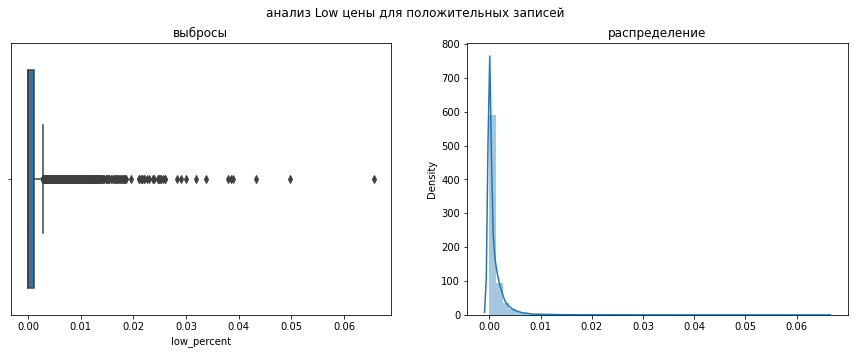

In [86]:
fig, axes = plt.subplots(1,2,figsize = (15,5))
fig.suptitle("анализ Low цены для положительных записей")

sns.boxplot(ax =axes[0], x = true_df["low_percent"])
axes[0].set_title("выбросы")

sns.distplot(ax = axes[1], x = true_df["low_percent"])
axes[1].set_title("распределение")

plt.show()

надо найти тот процент закрытия сделки, который принесет нам максимальную прибыль

мы имеем модель с 84% точностью определяющую возрастание цены в след минуту

будем идти по процентилем и смотреть на мат ожидание каждого варианта цены закрытия

In [41]:
percentiles = np.arange(50,101,5)

In [55]:
percentiles_list = [(percent, np.percentile(true_df["low_percent"], percent)) for percent in percentiles]
print(percentiles_list)

[(50, 8.753647353065293e-05), (55, 0.0002474323292844704), (60, 0.00042444310912008345), (65, 0.0006170248152400317), (70, 0.0008652422347044428), (75, 0.0011481380424612244), (80, 0.0015068925922106392), (85, 0.00196903338039341), (90, 0.002635805217665994), (95, 0.004118161072688446), (100, 0.06564816092607166)]


Для тестов возьмем все эти значения стоп лосс цен

Пояснения:

    процентиль 60,допустим, означает, что мы ставим стоп лосс цену на 0.0004244% от цены открытия,
    а также отсекаем 40% потенциально плюсовых сделок

Получается, из всех предсказаных моделью положительных сделок, 84 будут истинно верны

Соответственно, в 84% будут приносить по 0.5% от ставки, а остальные 16% будут закрыты по стоп лосс цене

Но, из этих 84% лишь число процентиля будет приносить выгоду, а остальные проценты также будут закрыты по стоп лоссу

Давайте рассчитаем нашу прибыль за, допустим, n входов в сделку(модель n раз определила, что за следующую минуту 
                                                                 цена вырастет более чем на 0.5%)

Пометка: прибылью в примере будем считать ровно 0.5% от сделки, хотя на практике за минуту цена может подскачить более, чем на 0.5%

In [76]:
#определим функцию и применим ее к нашим тестовым стоп лоссам и процентилем
def stonks(min_profit,percentile, stop_loss, n_sdelok):
    minus_1 = 0.16*stop_loss
    minus_2 = 0.84*((100-percentile)/100)*stop_loss
    plus_1 = 0.84*(percentile/100)*min_profit
    
    return f"итоговый профит от {n_sdelok} сделок : {(minus_1+minus_2+plus_1)*n_sdelok} со стоп лоссом {stop_loss} и процентом отсечения {100-percentile}"

In [69]:
for i in percentiles_list:
    print(stonks(0.005,i[0],i[1],100))

итоговый профит от 100 сделок : 0.21507711546477787 со стоп лоссом 8.753647353065293e-05 и процентом отсечения 50
итоговый профит от 100 сделок : 0.24431185931550453 со стоп лоссом 0.0002474323292844704 и процентом отсечения 45
итоговый профит от 100 сделок : 0.2730523782123562 со стоп лоссом 0.00042444310912008345 и процентом отсечения 40
итоговый профит от 100 сделок : 0.3010129266118975 со стоп лоссом 0.0006170248152400317 и процентом отсечения 35
итоговый профит от 100 сделок : 0.32964798006982304 со стоп лоссом 0.0008652422347044428 и процентом отсечения 30
итоговый профит от 100 сделок : 0.35748110757106527 со стоп лоссом 0.0011481380424612244 и процентом отсечения 25
итоговый профит от 100 сделок : 0.385426077024509 со стоп лоссом 0.0015068925922106392 и процентом отсечения 20
итоговый профит от 100 сделок : 0.4133143546792515 со стоп лоссом 0.00196903338039341 и процентом отсечения 15
итоговый профит от 100 сделок : 0.4423136473110502 со стоп лоссом 0.002635805217665994 и проце

По результатам лучшее мат ожидание модели при стоп лоссе 6.5% от цены открытия. Или, другими словами, отсутствие стоп лосса, поскольку 6.5% - это макс отклонение из выборки.

Но, как по мне, это большой риск. Для первых тестов модели сделаем стоп лосс на 0.26% и процентом отсечения 10